<a href="https://colab.research.google.com/github/DavidRamosArchilla/Firewall-AI/blob/main/notebooks/Data_processing_and_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Downloading and preprocessing the *dataset*

In [ ]:
!wget http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-03-11.zip

--2023-10-31 16:18:00--  http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-03-11.zip
Connecting to 205.174.165.80:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918815761 (876M) [application/zip]
Saving to: ‘CSV-03-11.zip’

CSV-03-11.zip       100%[===================>] 876.25M  1.32MB/s    in 11m 25s 

2023-10-31 16:29:25 (1.28 MB/s) - ‘CSV-03-11.zip’ saved [918815761/918815761]



In [ ]:
!unzip CSV-03-11.zip

Archive:  CSV-03-11.zip
   creating: 03-11/
  inflating: 03-11/UDPLag.csv        
  inflating: 03-11/UDP.csv           
  inflating: 03-11/.~lock.UDPLag.csv#  
  inflating: 03-11/LDAP.csv          
  inflating: 03-11/MSSQL.csv         
  inflating: 03-11/NetBIOS.csv       
  inflating: 03-11/Portmap.csv       
  inflating: 03-11/Syn.csv           


In [ ]:
import pandas as pd
import numpy as np

import os
from pathlib import Path

In [ ]:
WORKING_DIR = Path.cwd()
DATA_UNPROCESSED = WORKING_DIR / "03-11"
DATA_PROCESSED = WORKING_DIR / "processed_files"

In [ ]:
def transform_column_types(df):
    # Convert any float columns to float32 format
    df = df.apply(lambda x: x.astype("float32") if np.issubdtype(x.dtype, np.floating) else x)

    # Convert any int columns to int32 format
    df = df.apply(lambda x: x.astype("int32") if np.issubdtype(x.dtype, np.integer) else x)

    return df

def prerpocess_dataframe(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = transform_column_types(df)
    final_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",final_mem_usg," MB")
    return df

def load_file(file_path):
     df = pd.read_csv(file_path,
                      usecols=lambda column: column not in columns_to_exclude)
     return prerpocess_dataframe(df)

In [ ]:
columns_to_exclude = ['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Timestamp', 'SimillarHTTP']

for file in os.listdir(DATA_UNPROCESSED):
    if file != 'MSSQL.csv' and file.endswith('.csv'):
        df = load_file(DATA_UNPROCESSED / file)
        basename = file.split('.')[0]
        df.to_parquet(DATA_PROCESSED / f"{basename}.parquet")
        print(file, ':\n', df[' Label'].value_counts())

Memory usage of properties dataframe is : 1289.8157958984375  MB
Memory usage of properties dataframe is : 7.577663421630859  MB
LDAP.csv :
 LDAP       17792
BENIGN      4643
NetBIOS     1498
Name:  Label, dtype: int64
Memory usage of properties dataframe is : 2109.3134765625  MB
Memory usage of properties dataframe is : 3.5854034423828125  MB
NetBIOS.csv :
 NetBIOS    10070
BENIGN      1254
Name:  Label, dtype: int64
Memory usage of properties dataframe is : 2637.049072265625  MB
Memory usage of properties dataframe is : 152.02978134155273  MB
Syn.csv :
 Syn       452953
BENIGN     27212
Name:  Label, dtype: int64
Memory usage of properties dataframe is : 442.605712890625  MB
Memory usage of properties dataframe is : 44.26915740966797  MB
UDPLag.csv :
 Syn       79060
UDP       56522
BENIGN     3781
UDPLag      455
Name:  Label, dtype: int64
Memory usage of properties dataframe is : 117.0008544921875  MB
Memory usage of properties dataframe is : 1.9282150268554688  MB
Portmap.csv :
 B

In [ ]:
df_mssql = pd.read_csv(DATA_UNPROCESSED / 'MSSQL.csv',
                       usecols=lambda column: column not in columns_to_exclude,
                       skiprows=lambda x: x != 0 and x < 4e6)
prerpocess_dataframe(df_mssql).to_parquet(DATA_PROCESSED / 'MSSQL_first_half.parquet')

Memory usage of properties dataframe is : 1083.8544921875  MB
Memory usage of properties dataframe is : 41.62253189086914  MB


In [ ]:
df_mssql = pd.read_csv(DATA_UNPROCESSED / 'MSSQL.csv',
                       usecols=lambda column: column not in columns_to_exclude,
                       skiprows=lambda x: x != 0 and x >= 2e6)
prerpocess_dataframe(df_mssql).to_parquet(DATA_PROCESSED / 'MSSQL_second_half.parquet')

Memory usage of properties dataframe is : 1220.70263671875  MB
Memory usage of properties dataframe is : 45.95484161376953  MB


In [ ]:
df_mssql = pd.read_csv(DATA_UNPROCESSED / 'MSSQL.csv',
                       usecols=lambda column: column not in columns_to_exclude,
                       skiprows=lambda x: x != 0 and (x < 2e6 or x >= 4e6))
prerpocess_dataframe(df_mssql).to_parquet(DATA_PROCESSED / 'MSSQL_third_half.parquet')

Memory usage of properties dataframe is : 1220.7032470703125  MB
Memory usage of properties dataframe is : 45.2589111328125  MB


In [ ]:
!zip -r preprocessed_files.zip "$DATA_PROCESSED"

/content/processed_filess

zip error: Nothing to do! (preprocessed_files.zip)


In [ ]:
!cp preprocessed_files.zip /content/drive/MyDrive/tfg_firewall

##Training the models

In [ ]:
!pip install -q hvplot

In [ ]:
%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
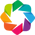

In [ ]:
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import metrics

In [ ]:
WORKING_DIR = Path.cwd()
PROCESSED_DATASET_FILE = Path('/content/drive/MyDrive/tfg_firewall/preprocessed_files.zip')
PROCESSED_DATA_DIR = WORKING_DIR / "processed_dataset"
PARQUET_FILES = PROCESSED_DATA_DIR / "content" / "processed_files"

In [ ]:
!unzip "$PROCESSED_DATASET_FILE" -d "$PROCESSED_DATA_DIR"

Archive:  /content/drive/MyDrive/tfg_firewall/preprocessed_files.zip
   creating: /content/processed_dataset/content/processed_files/
  inflating: /content/processed_dataset/content/processed_files/UDPLag.parquet  
  inflating: /content/processed_dataset/content/processed_files/NetBIOS.parquet  
  inflating: /content/processed_dataset/content/processed_files/LDAP.parquet  
  inflating: /content/processed_dataset/content/processed_files/.parquet  
  inflating: /content/processed_dataset/content/processed_files/MSSQL_third_half.parquet  
  inflating: /content/processed_dataset/content/processed_files/Portmap.parquet  
  inflating: /content/processed_dataset/content/processed_files/UDP.parquet  
  inflating: /content/processed_dataset/content/processed_files/MSSQL_first_half.parquet  
  inflating: /content/processed_dataset/content/processed_files/MSSQL_second_half.parquet  
  inflating: /content/processed_dataset/content/processed_files/Syn.parquet  


###Loading preprocessed dataset

In [ ]:
df_list = [pd.read_parquet(PARQUET_FILES / file) for file in os.listdir(PARQUET_FILES)]

In [ ]:
df = pd.concat(df_list)
df = df.iloc[:, :-4]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df

Protocol   Flow Duration   Total Fwd Packets  \
0            17.0             1.0                 2.0   
2            17.0             1.0                 2.0   
3            17.0             1.0                 2.0   
4            17.0             1.0                 2.0   
5            17.0             1.0                 2.0   
...           ...             ...                 ...   
177618       17.0           147.0                 2.0   
180085       17.0            97.0                 2.0   
180921       17.0             1.0                 2.0   
187889       17.0            48.0                 2.0   
190576       17.0           187.0                 2.0   

         Total Backward Packets  Total Length of Fwd Packets  \
0                           0.0                       2560.0   
2                           0.0                        810.0   
3                           0.0                        852.0   
4                           0.0                       1240.0   
5                           0.0                       1064.0   
...                         ...                          ...   
177618                      0.0                        458.0   
180085                      0.0                        458.0   
180921                      0.0                        100.0   
187889                      0.0                        674.0   
190576                      0.0                        422.0   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                0.0                  1280.0   
2                                0.0                   405.0   
3                                0.0                   426.0   
4                                0.0                   620.0   
5                                0.0                   532.0   
...                              ...                     ...   
177618                           0.0                   229.0   
180085                           0.0                   229.0   
180921                           0.0                    50.0   
187889                           0.0                   337.0   
190576                           0.0                   211.0   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
0                       1280.0                   1280.0   
2                        405.0                    405.0   
3                        426.0                    426.0   
4                        620.0                    620.0   
5                        532.0                    532.0   
...                        ...                      ...   
177618                   229.0                    229.0   
180085                   229.0                    229.0   
180921                    50.0                     50.0   
187889                   337.0                    337.0   
190576                   211.0                    211.0   

         Fwd Packet Length Std  ...  Active Mean   Active Std   Active Max  \
0                          0.0  ...          0.0          0.0          0.0   
2                          0.0  ...          0.0          0.0          0.0   
3                          0.0  ...          0.0          0.0          0.0   
4                          0.0  ...          0.0          0.0          0.0   
5                          0.0  ...          0.0          0.0          0.0   
...                        ...  ...          ...          ...          ...   
177618                     0.0  ...          0.0          0.0          0.0   
180085                     0.0  ...          0.0          0.0          0.0   
180921                     0.0  ...          0.0          0.0          0.0   
187889                     0.0  ...          0.0          0.0          0.0   
190576                     0.0  ...          0.0          0.0          0.0   

         Active Min  Idle Mean   Idle Std   Idle Max   Idle Min   Inbound  \
0               0.0        0.0        0.0        0.0        0.0

In [ ]:
df.keys() # quitar: ' Fwd Header Length.1', ' act_data_pkt_fwd',' min_seg_size_forward', ' Inbound' ¿protocol?

Index([' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag

In [ ]:
df = df.drop(columns=[' Fwd Header Length.1', ' act_data_pkt_fwd',' min_seg_size_forward', ' Inbound'])

In [ ]:
df[' Label'].value_counts()

UDP        1345065
Syn         532006
MSSQL       395613
BENIGN       46523
LDAP         17042
NetBIOS      11312
Portmap       1599
UDPLag         455
Name:  Label, dtype: int64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
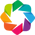

:Bars   [index]   ( Label)

In [ ]:
hv.extension('bokeh')
df[' Label'].value_counts().hvplot.bar(height=450, width=650, grid=True)

In [ ]:
def remove_rows_by_class(df, class_label, target_amount):
    return df.groupby(' Label', group_keys=False).apply(
        lambda group: group.sample(n=min(target_amount, len(group)))
    )

In [ ]:
df = remove_rows_by_class(df, 'UDP', 46864)
df = remove_rows_by_class(df, 'Syn', 46864)
df = remove_rows_by_class(df, 'MSSQL', 46864)
df = df[(df[' Label'] != 'NetBIOS') & (df[' Label'] != 'Portmap') & (df[' Label'] != 'UDPLag')]

In [ ]:
df[' Label'].value_counts()

MSSQL     46864
Syn       46864
UDP       46864
BENIGN    46523
LDAP      17042
Name:  Label, dtype: int64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
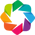

:Bars   [index]   ( Label)

In [ ]:
hv.extension('bokeh')
df[' Label'].value_counts().hvplot.bar(height=450, width=650, grid=True)

In [ ]:
X = df.drop(columns=[' Label']).values
Y = df[' Label'].values

In [ ]:
starndard_scaler = StandardScaler()
X = starndard_scaler.fit_transform(X)

In [ ]:
from joblib import dump

dump(starndard_scaler, 'std_scaler.bin')

['std_scaler.bin']

In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

In [ ]:
dump(label_encoder, 'label_encoder.bin')

['label_encoder.bin']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(163325, 75)
(40832, 75)
(163325,)
(40832,)


### Dimensionality reduction

In [ ]:
!pip install -q umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


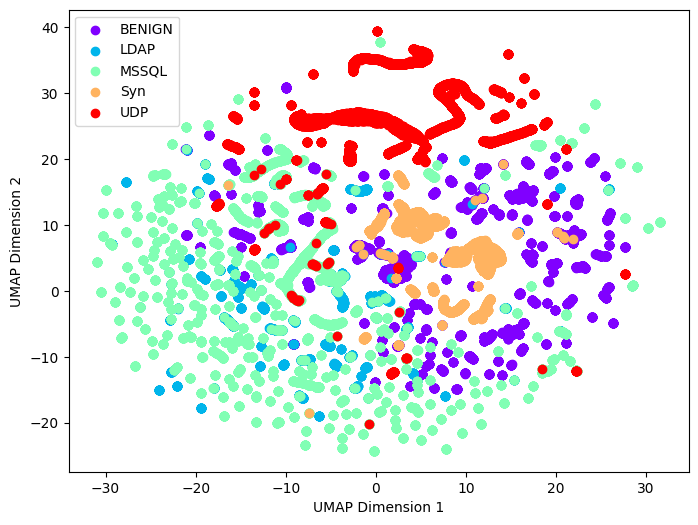

In [ ]:
import matplotlib.pyplot as plt
import umap


umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    n_epochs=1000,
)
X_umap = umap_model.fit_transform(X_test)

plt.figure(figsize=(8, 6))

unique_labels = label_encoder.inverse_transform(list(set(Y)))

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    X_label = X_umap[label_encoder.inverse_transform(y_test) == label]
    plt.scatter(X_label[:, 0], X_label[:, 1], color=colors[i], label=label)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(loc='best')

plt.show()

In [ ]:
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


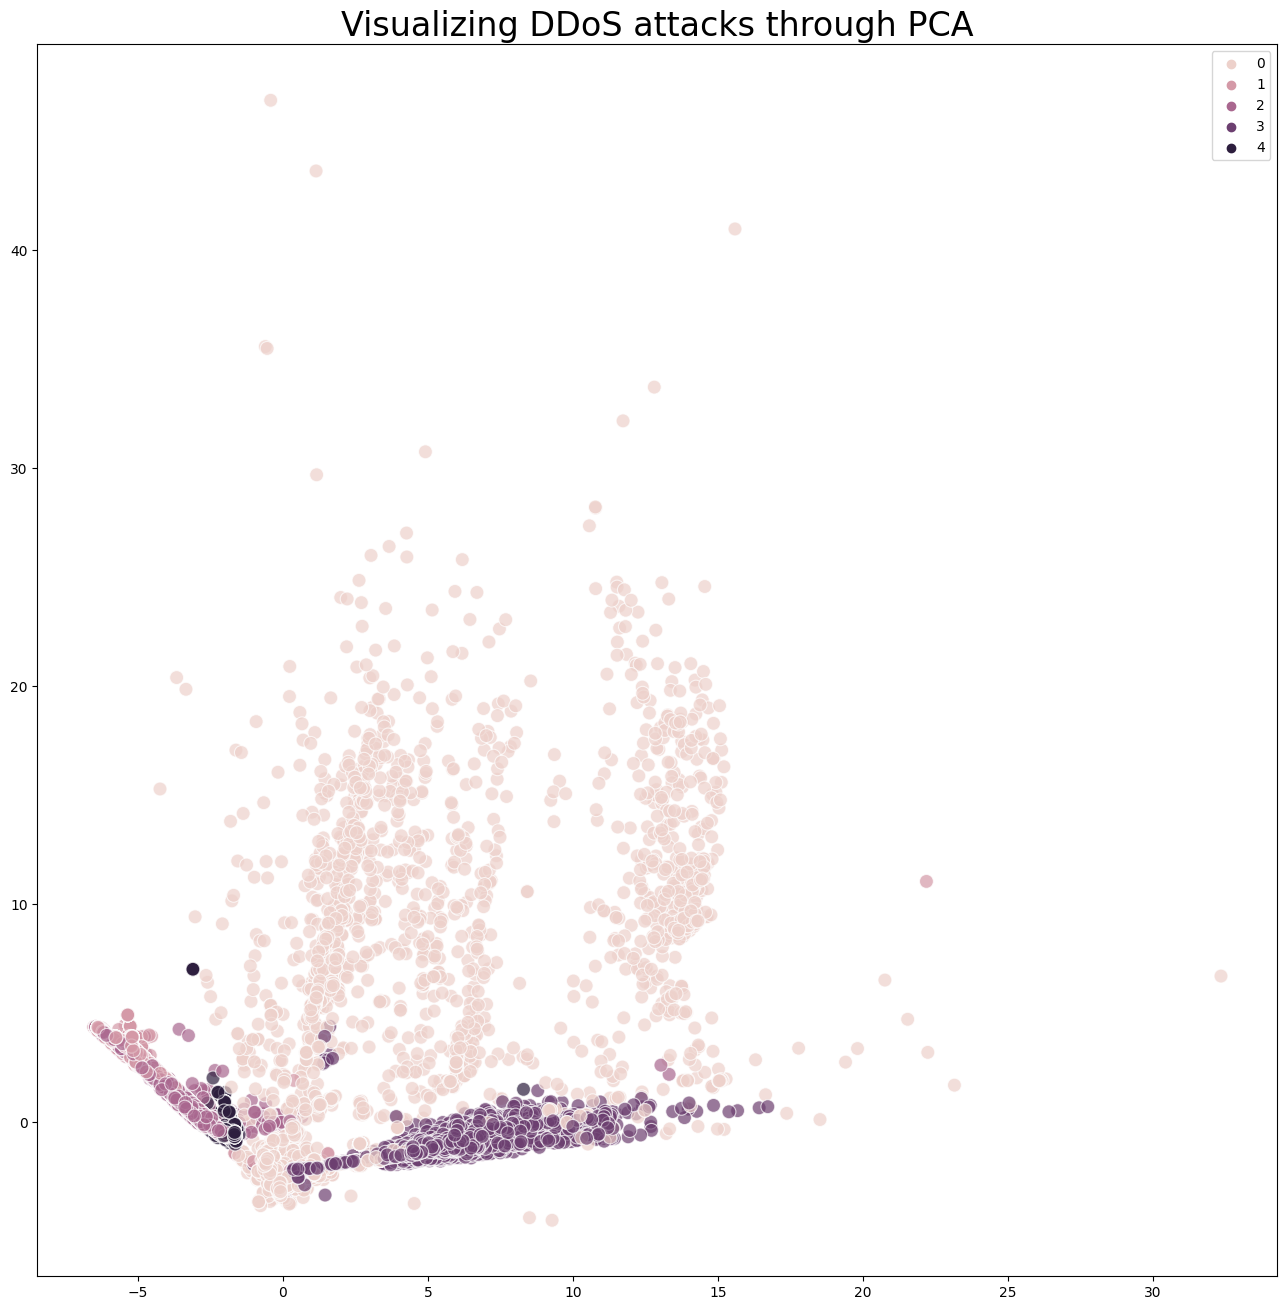

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test)
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], s= 100, hue=y_test, cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through PCA', fontsize=24);

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


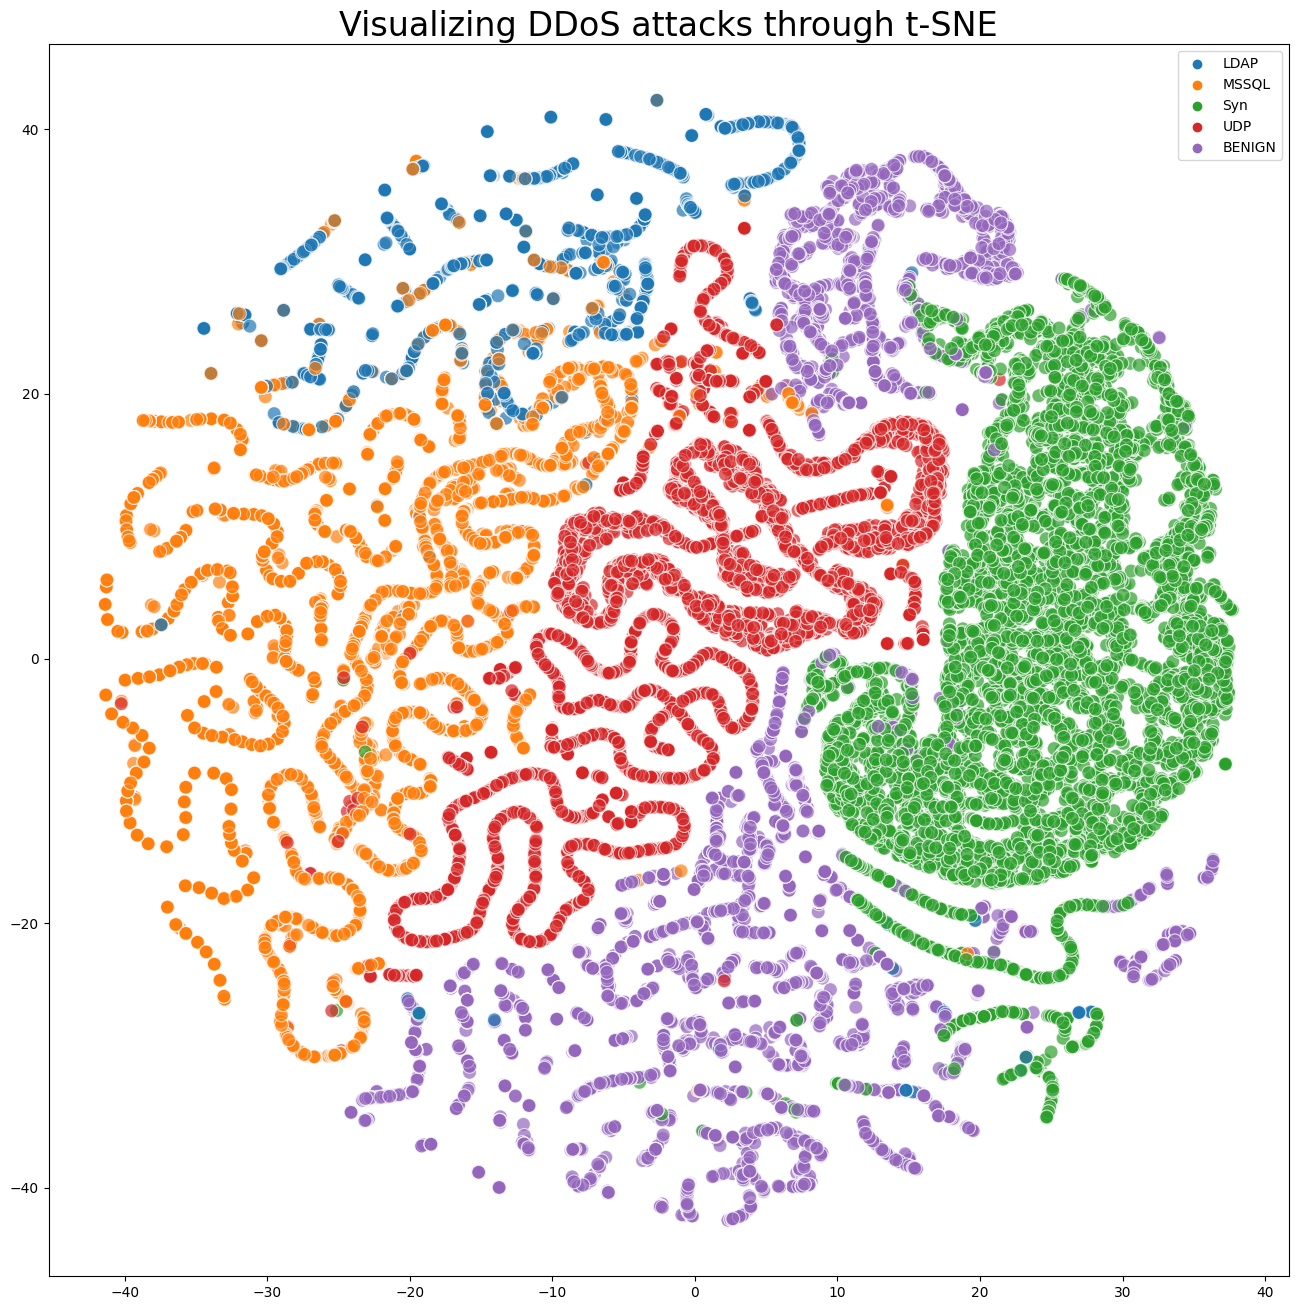

In [ ]:
from sklearn.manifold import TSNE

tsne_ = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=30, n_iter=400).fit_transform(principalComponents)
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(x=tsne_[:, 0], y=tsne_[:, 1], s= 100, hue=label_encoder.inverse_transform(y_test), cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through t-SNE', fontsize=24);

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


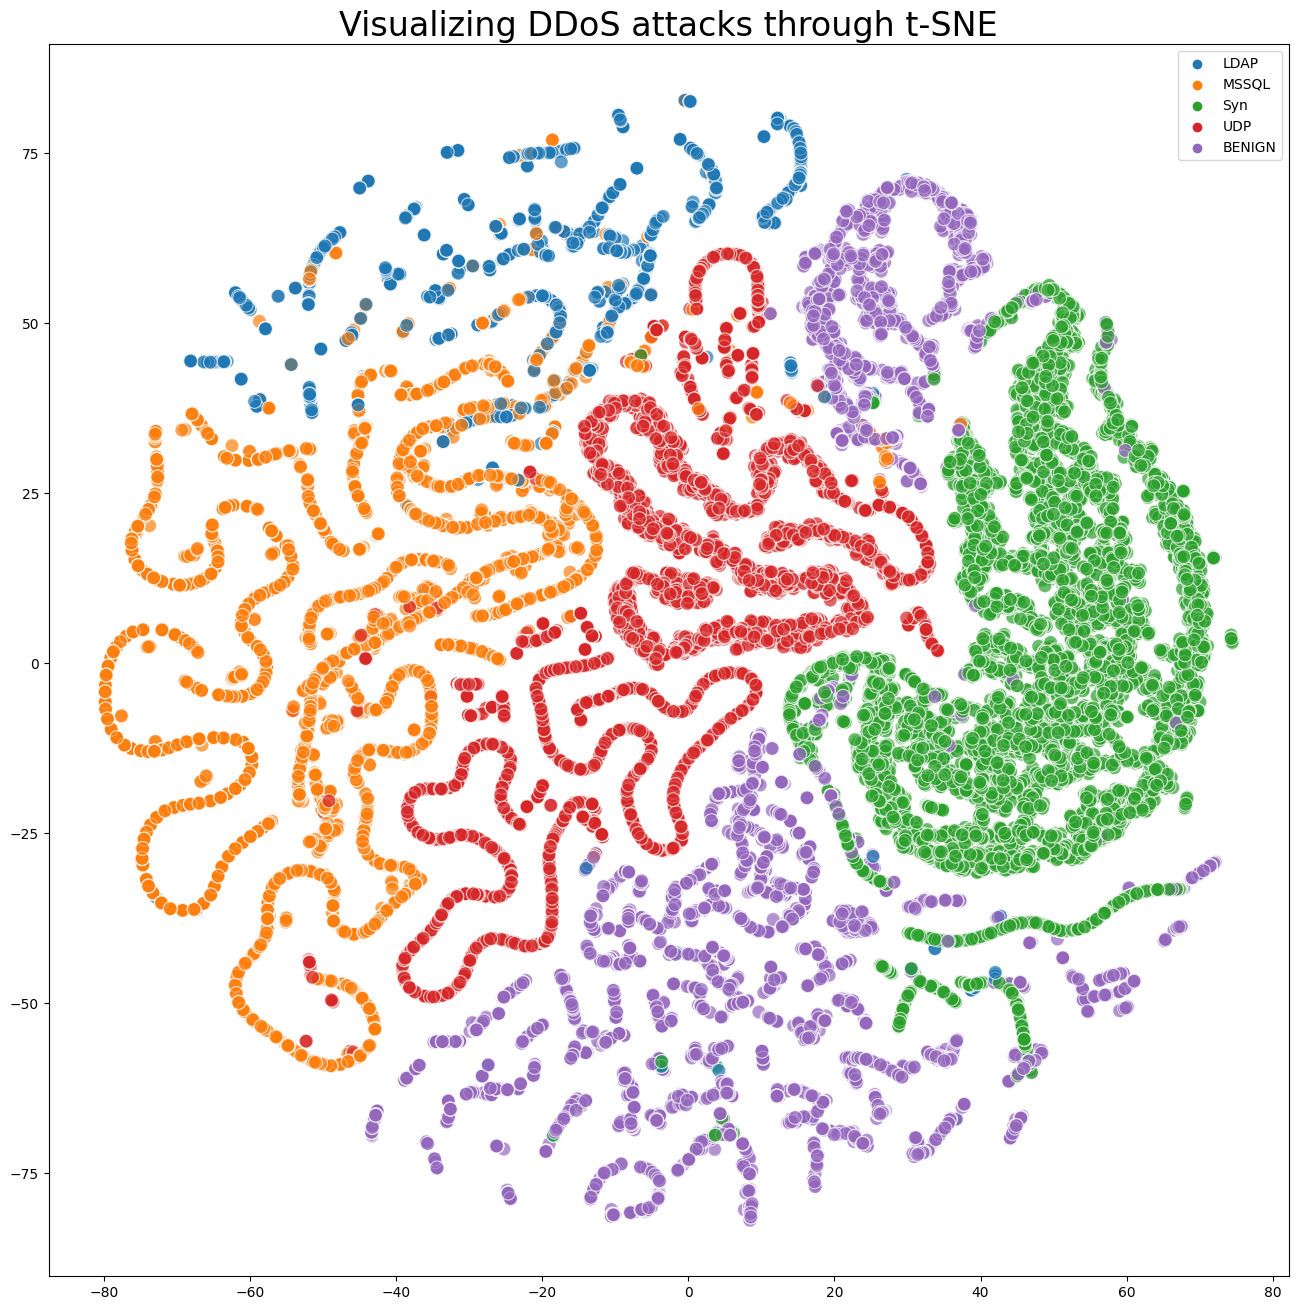

In [ ]:
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(x=tsne_[:, 0], y=tsne_[:, 1], s= 100, hue=label_encoder.inverse_transform(y_test), cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through t-SNE', fontsize=24);

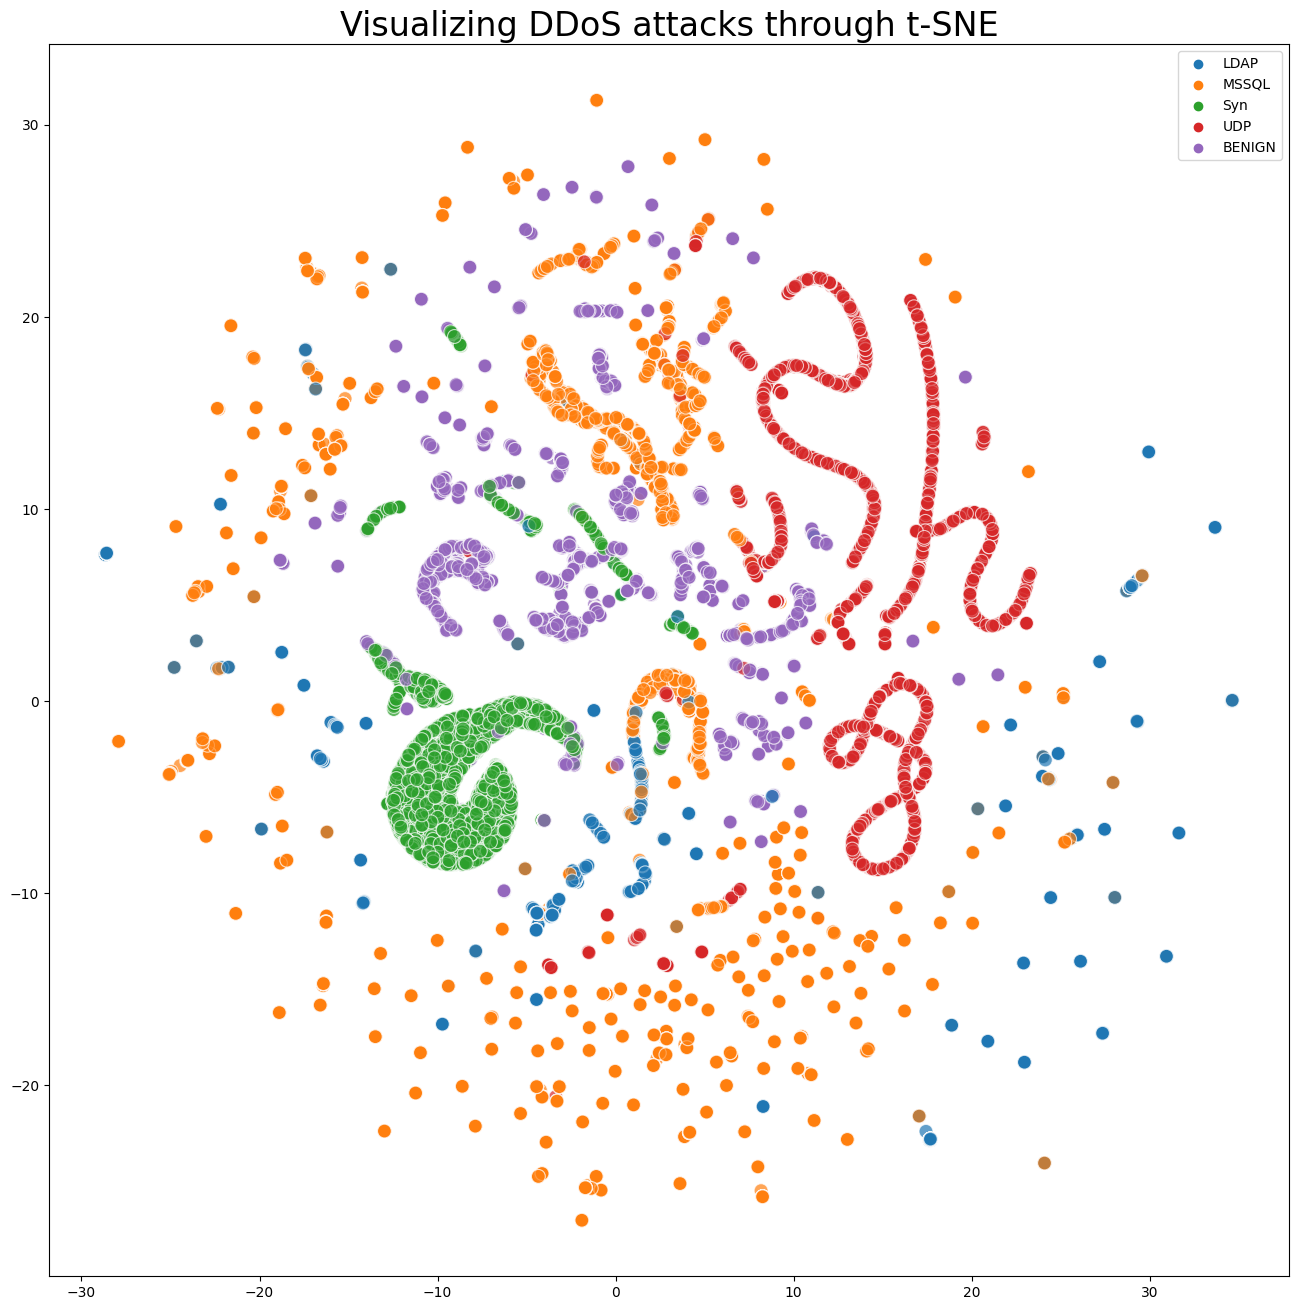

In [ ]:
import umap

umap_model = umap.UMAP(
    n_neighbors=40,
    min_dist=0.1,
    n_components=2,
    n_epochs=500,  # Adjust as needed
)
  # You can adjust the number of components as needed
X_umap = umap_model.fit_transform(principalComponents)

plt.figure(figsize=(16,16))
g1 = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], s= 100, hue=label_encoder.inverse_transform(y_test),alpha=0.7)
plt.title('Visualizing DDoS attacks through t-SNE', fontsize=24);

###Neural network training

In [ ]:
N_FEATURES = X_train.shape[1]
N_CLASSES = len(label_encoder.classes_)
def create_model(n_features, n_classes):
    input = layers.Input(shape=(n_features, ))
    x = layers.Dense(64, activation='relu')(input)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=out)

    learning_rate = 5e-4
    training_metrics = [
        metrics.Precision(name='Precision'),
        metrics.Recall(name='Recall'),
        metrics.F1Score(name='F1Score')
    ]

    model.compile(
        optimizer=AdamW(learning_rate),
        loss=CategoricalCrossentropy(),
        metrics=training_metrics
    )
    return model

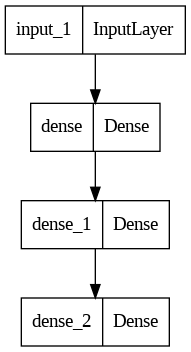

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(create_model(75, 5))

In [ ]:
create_model(75, 5).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                4864      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 9349 (36.52 KB)
Trainable params: 9349 (36.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Cross-validation

Fold 1:


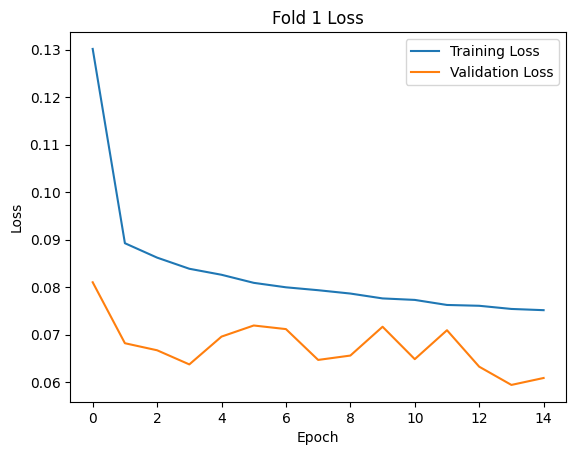

1021/1021 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      7443
        LDAP       0.85      0.96      0.90      2739
       MSSQL       0.98      0.94      0.96      7495
         Syn       1.00      1.00      1.00      7501
         UDP       1.00      0.99      1.00      7487

    accuracy                           0.98     32665
   macro avg       0.96      0.98      0.97     32665
weighted avg       0.98      0.98      0.98     32665

Fold 2:


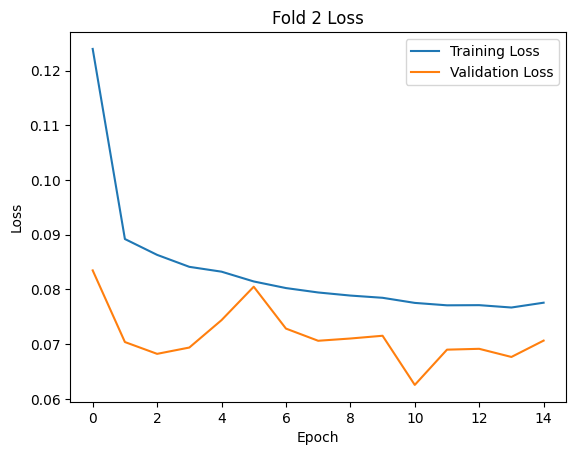

1021/1021 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      BENIGN       0.99      1.00      0.99      7443
        LDAP       0.82      0.98      0.89      2739
       MSSQL       0.99      0.92      0.95      7495
         Syn       1.00      0.99      0.99      7501
         UDP       1.00      1.00      1.00      7487

    accuracy                           0.98     32665
   macro avg       0.96      0.98      0.97     32665
weighted avg       0.98      0.98      0.98     32665

Fold 3:


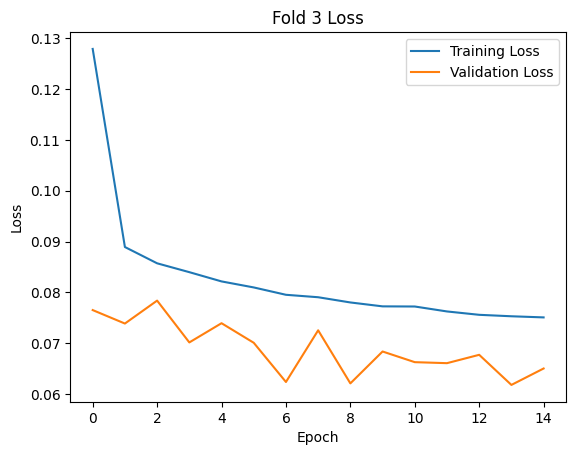

1021/1021 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00      7443
        LDAP       0.84      0.97      0.90      2739
       MSSQL       0.99      0.93      0.96      7495
         Syn       1.00      1.00      1.00      7501
         UDP       1.00      1.00      1.00      7487

    accuracy                           0.98     32665
   macro avg       0.96      0.98      0.97     32665
weighted avg       0.98      0.98      0.98     32665

Fold 4:


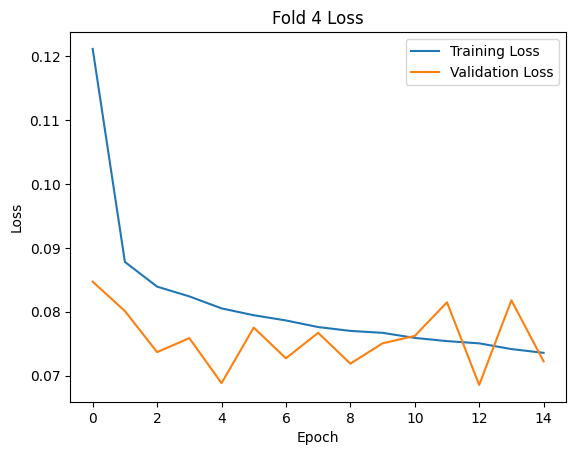

1021/1021 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00      7443
        LDAP       0.83      0.97      0.90      2740
       MSSQL       0.98      0.93      0.96      7495
         Syn       1.00      0.99      1.00      7501
         UDP       1.00      0.99      1.00      7486

    accuracy                           0.98     32665
   macro avg       0.96      0.98      0.97     32665
weighted avg       0.98      0.98      0.98     32665

Fold 5:


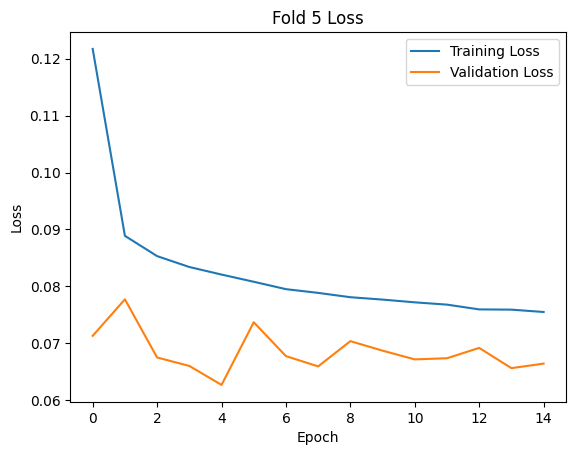

1021/1021 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      7443
        LDAP       0.84      0.96      0.90      2740
       MSSQL       0.98      0.93      0.96      7496
         Syn       1.00      1.00      1.00      7500
         UDP       1.00      1.00      1.00      7486

    accuracy                           0.98     32665
   macro avg       0.96      0.98      0.97     32665
weighted avg       0.98      0.98      0.98     32665



In [ ]:
bs = 32
epochs = 15

skf = StratifiedKFold(n_splits=5)
fold_idx = 0
for train_index, test_index in skf.split(X_train, y_train):
    print(f"Fold {fold_idx + 1}:")
    X_train_fold, X_test_fold = X_train[train_index, :], X_train[test_index, :]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    model = create_model(N_FEATURES, N_CLASSES)
    history = model.fit(
        X_train_fold,
        tf.keras.utils.to_categorical(y_train_fold),
        validation_data=(X_test_fold, tf.keras.utils.to_categorical(y_test_fold)),
        batch_size=bs,
        class_weight=class_weights,
        epochs=epochs,
        verbose=0
    )
    model.save(f"model_{fold_idx}.keras")
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_idx + 1} Loss')
    plt.legend()
    plt.show()

    y_pred = model.predict(X_test_fold)
    report = classification_report(y_test_fold,
                                   np.argmax(y_pred, axis=1),
                                   target_names=label_encoder.classes_)
    print(report)
    fold_idx += 1

Final training

Epoch 1/15
5104/5104 [==============================] - 18s 3ms/step - loss: 0.1163 - Precision: 0.9753 - Recall: 0.9648 - F1Score: 0.9601 - val_loss: 0.0831 - val_Precision: 0.9767 - val_Recall: 0.9763 - val_F1Score: 0.9657
Epoch 2/15
5104/5104 [==============================] - 17s 3ms/step - loss: 0.0878 - Precision: 0.9775 - Recall: 0.9771 - F1Score: 0.9670 - val_loss: 0.0748 - val_Precision: 0.9777 - val_Recall: 0.9777 - val_F1Score: 0.9672
Epoch 3/15
5104/5104 [==============================] - 17s 3ms/step - loss: 0.0842 - Precision: 0.9780 - Recall: 0.9777 - F1Score: 0.9677 - val_loss: 0.0726 - val_Precision: 0.9786 - val_Recall: 0.9784 - val_F1Score: 0.9680
Epoch 4/15
5104/5104 [==============================] - 17s 3ms/step - loss: 0.0830 - Precision: 0.9783 - Recall: 0.9779 - F1Score: 0.9680 - val_loss: 0.0705 - val_Precision: 0.9784 - val_Recall: 0.9782 - val_F1Score: 0.9677
Epoch 5/15
5104/5104 [==============================] - 18s 4ms/step - loss: 0.0808 - Precision: 0.9

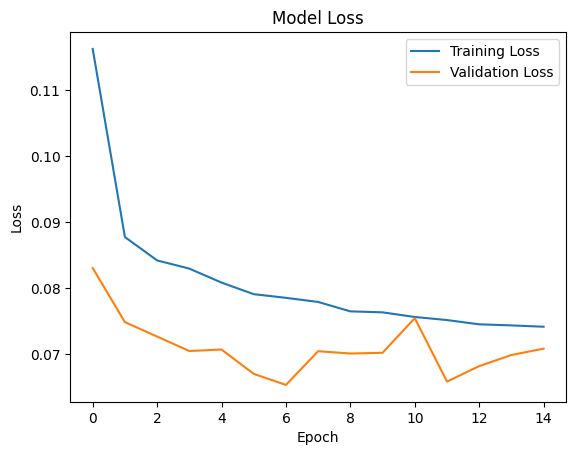

1276/1276 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99      9308
        LDAP       0.82      0.96      0.89      3345
       MSSQL       0.98      0.93      0.96      9388
         Syn       1.00      1.00      1.00      9360
         UDP       1.00      0.99      1.00      9431

    accuracy                           0.98     40832
   macro avg       0.96      0.98      0.97     40832
weighted avg       0.98      0.98      0.98     40832



In [ ]:
bs = 32
epochs = 15
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
model = create_model(N_FEATURES, N_CLASSES)
history = model.fit(
    X_train,
    tf.keras.utils.to_categorical(y_train),
    validation_data=(X_test, tf.keras.utils.to_categorical(y_test)),
    batch_size=bs,
    class_weight=class_weights,
    epochs=epochs,
    verbose=1
)
model.save("final_model.keras")
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
report = classification_report(y_test,
                                np.argmax(y_pred, axis=1),
                                target_names=label_encoder.classes_)
print(report)

In [ ]:
label_encoder.classes_

array(['BENIGN', 'LDAP', 'MSSQL', 'Syn', 'UDP'], dtype=object)

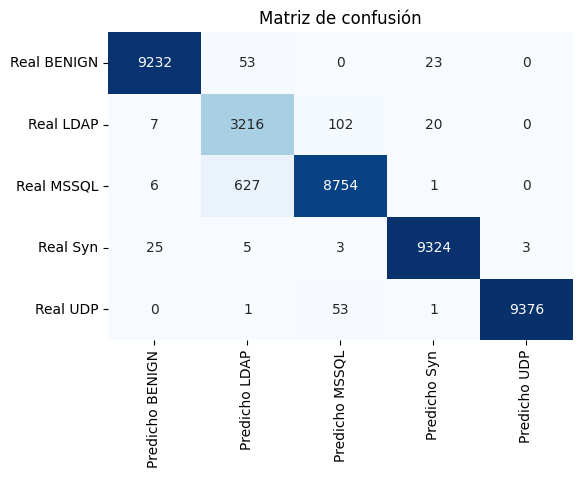

In [ ]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicho BENIGN', 'Predicho LDAP', 'Predicho MSSQL', 'Predicho Syn', 'Predicho UDP'],
            yticklabels=['Real BENIGN', 'Real LDAP', 'Real MSSQL','Real Syn', 'Real UDP'])

plt.title('Matriz de confusión')
plt.show()

### XGBoost with optuna

In [ ]:
!pip install -q optuna

In [ ]:
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'device': 'gpu',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1300),
        'num_class': len(set(Y)),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    scores = cross_val_score(model, X_val, y_val, cv=5, scoring='accuracy')

    return scores.mean()

study = optuna.create_study(direction='maximize', study_name='Classifier')
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

[I 2023-11-27 14:27:35,490] A new study created in memory with name: Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-27 14:28:08,345] Trial 0 finished with value: 0.9919670846394985 and parameters: {'lambda': 0.014454456287197201, 'alpha': 0.0009006434034147474, 'max_depth': 8, 'eta': 0.0560599191042471, 'gamma': 6.387479618950635e-06, 'colsample_bytree': 0.7597298419549491, 'min_child_weight': 7, 'n_estimators': 1238}. Best is trial 0 with value: 0.9919670846394985.
[I 2023-11-27 14:28:45,541] Trial 1 finished with value: 0.984375 and parameters: {'lambda': 8.348154058792096e-07, 'alpha': 2.349848718195714e-06, 'max_depth': 9, 'eta': 0.00010850007431146628, 'gamma': 4.1622745321661175e-05, 'colsample_bytree': 0.10440983015463895, 'min_child_weight': 4, 'n_estimators': 1148}. Best is trial 0 with value: 0.9919670846394985.
[I 2023-11-27 14:29:08,412] Trial 2 finished with value: 0.9879996081504702 and parameters: {'lambda': 0.9139749313516832, 'alpha': 0.0034472981755717005, 'max_depth': 9, 'eta': 4.1166852972773846e-07, 'gamma': 0.002490346696325672, 'colsample_bytree': 0.4436671537873475

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate

plot_optimization_history(study).show()

In [ ]:
plot_param_importances(study).show()

In [ ]:
plot_parallel_coordinate(study).show()

In [ ]:
results = [{"val": np.mean(trial.values), "params": trial.params} for trial in study.get_trials()]
results = sorted(results, key=lambda x: x["val"], reverse=True)

In [ ]:
best_params = study.best_params
print(best_params)

{'lambda': 3.242851557666658e-06, 'alpha': 1.8440002794817977e-06, 'max_depth': 9, 'eta': 0.1294208168667795, 'gamma': 8.192698273313952e-07, 'colsample_bytree': 0.14470448735955996, 'min_child_weight': 6, 'n_estimators': 1023}


In [ ]:
# in case the session is reseted and i lose the value of the variable
# best_params = {'lambda': 3.242851557666658e-06, 'alpha': 1.8440002794817977e-06, 'max_depth': 9, 'eta': 0.1294208168667795, 'gamma': 8.192698273313952e-07, 'colsample_bytree': 0.14470448735955996, 'min_child_weight': 6, 'n_estimators': 1023}


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
     df.drop(columns=[' Label']), Y, test_size=0.2, random_state=42, shuffle=True)

model = xgb.XGBClassifier(**best_params)
model.fit(
    X_train, y_train,

)

XGBClassifier(alpha=1.8440002794817977e-06, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.14470448735955996, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.1294208168667795, eval_metric=None, feature_types=None,
              gamma=8.192698273313952e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=3.242851557666658e-06, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1023, ...)

In [ ]:
y_pred = model.predict(X_test)
report = classification_report(y_test,
                                   y_pred,
                                   target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      9308
        LDAP       0.95      0.97      0.96      3345
       MSSQL       0.99      0.98      0.98      9388
         Syn       1.00      1.00      1.00      9360
         UDP       1.00      1.00      1.00      9431

    accuracy                           0.99     40832
   macro avg       0.99      0.99      0.99     40832
weighted avg       0.99      0.99      0.99     40832



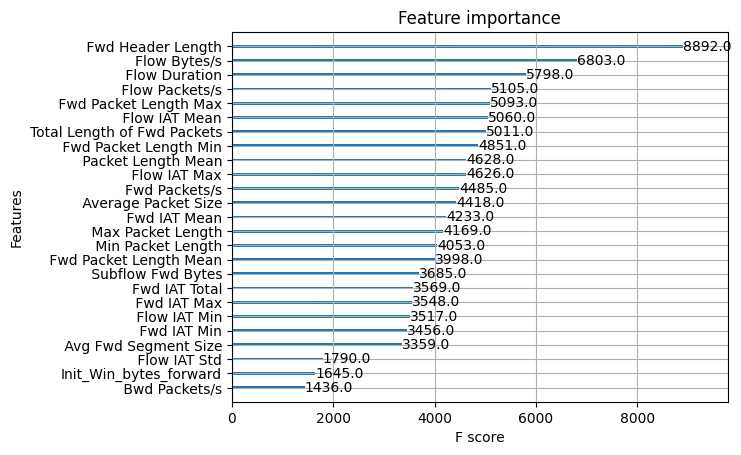

In [ ]:
xgb.plot_importance(model, max_num_features=25)
plt.show()

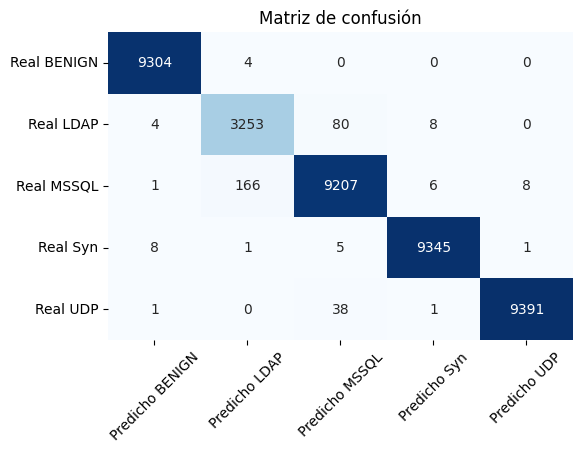

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicho BENIGN', 'Predicho LDAP', 'Predicho MSSQL', 'Predicho Syn', 'Predicho UDP'],
            yticklabels=['Real BENIGN', 'Real LDAP', 'Real MSSQL','Real Syn', 'Real UDP'])
plt.xticks(rotation=45)
plt.title('Matriz de confusión')
plt.show()

In [ ]:
import pickle

with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)